# Exploratory Analysis v2

To Do Items: https://github.com/Upward-Spiral-Science/the-vat/blob/master/Draft/to-do.md

For a certain channel that has repeated measurements, plot a downsampled scatter plot... Should be linear?

In [1]:
# Import Necessary Libraries
import numpy as np
import os, csv, json

from matplotlib import *
from matplotlib import pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import KernelDensity

from sklearn import cluster
from scipy.spatial import distance
import sklearn.datasets
from sklearn.preprocessing import StandardScaler

import pandas as pd

#### Set up R Independence Test 
np.random.seed(12345678)  # for reproducibility, set random seed
from rpy2 import robjects
from rpy2.robjects import r

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

# Channels
Here is the cell describing each channel column for each measurement metric. 

In [2]:
from pprint import pprint
# channel = ['Synap','Synap','VGlut1','VGlut1','VGlut2','Vglut3',
#            'psd','glur2','nmdar1','nr2b','gad','VGAT', 'PV','Gephyr',
#            'GABAR1','GABABR','CR1','5HT1A', 'NOS','TH','VACht',
#            'Synapo','tubuli','DAPI']

channel = ['Synap_01','Synap_02','VGlut1_01','VGlut1_02','VGlut2','Vglut3',
           'psd','glur2','nmdar1','nr2b','gad','VGAT', 'PV','Gephyr',
           'GABAR1','GABABR','CR1','5HT1A', 'NOS','TH','VACht',
           'Synapo','tubuli','DAPI']

channeltype = ['ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small', 
               'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre', 
               'in.pre','in.post','in.post','in.post','in.pre.small','other',
               'ex.post','other','other','ex.post','none','none']
print(channel)
print(channeltype)

['Synap_01', 'Synap_02', 'VGlut1_01', 'VGlut1_02', 'VGlut2', 'Vglut3', 'psd', 'glur2', 'nmdar1', 'nr2b', 'gad', 'VGAT', 'PV', 'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'tubuli', 'DAPI']
['ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'in.pre.small', 'ex.post', 'ex.post', 'ex.post', 'ex.post', 'in.pre', 'in.pre', 'in.pre', 'in.post', 'in.post', 'in.post', 'in.pre.small', 'other', 'ex.post', 'other', 'other', 'ex.post', 'none', 'none']


In [4]:
#### RUN AT BEGINNING AND TRY NOT TO RUN AGAIN - TAKES WAY TOO LONG ####
# load in the feature data
list_of_features = []
with open('../data/original data/synapsinR_7thA.tif.Pivots.txt.2011Features.txt') as file:
    for line in file:
        inner_list = [float(elt.strip()) for elt in line.split(',')]
        
        # create list of features
        list_of_features.append(inner_list)

# conver to a numpy matrix
list_of_features = np.array(list_of_features)

In [4]:
# SAVE ENTIRE TRANSFORMED DATA 
def normalize(X):
    mn = np.min(X, axis=0)
    mx = np.max(X, axis=0)
    rn = mx - mn
    X = np.array([(r - mn)/rn for r in X])
    return X

def log_transform(X, norm=False):
    X = np.log(normalize(X) + 1) if norm else np.log(X + 1)
    return X

def sqrt_transform(X, norm=False):
    X = np.sqrt(normalize(X)) if norm else np.sqrt(X)
    return X

X = list_of_features
Xlog = log_transform(X)
Xsq = sqrt_transform(X)
np.save('../data/synapse_features_log.npy',Xlog)
np.save('../data/synapse_features_sqrt.npy',Xsq)
Xlog = log_transform(X, norm=True)
Xsq = sqrt_transform(X, norm=True)
np.save('../data/synapse_features_log_normalized.npy',Xlog)
np.save('../data/synapse_features_sqrt_normalized.npy',Xsq)

(1119299, 144)


In [6]:
# SAVE ONLY F0 TRANSFORMED DATA
X_f0 = list_of_features[:,0:24]
X = X_f0
Xlog = log_transform(X)
Xsq = sqrt_transform(X)
np.save('../data/synapse_f0_features_log.npy',Xlog)
np.save('../data/synapse_f0_features_sqrt.npy',Xsq)
Xlog = log_transform(X, norm=True)
Xsq = sqrt_transform(X, norm=True)
np.save('../data/synapse_f0_features_log_normalized.npy',Xlog)
np.save('../data/synapse_f0_features_sqrt_normalized.npy',Xsq)

In [13]:
X_f0 = list_of_features[:,0:24]
X = X_f0
np.save('../data/synapse_f0_features.npy',X)

## Data Check
For data points where they were gathered twice, e.g. synap, and vglut1, should a random scatter plot lay on a line? It should be a simple linear transformation

(10000, 24) 




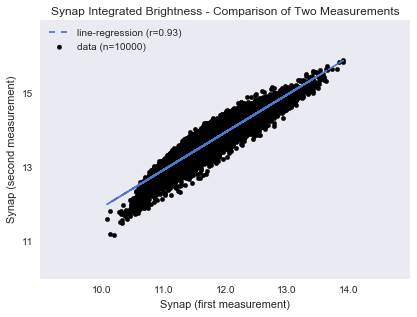

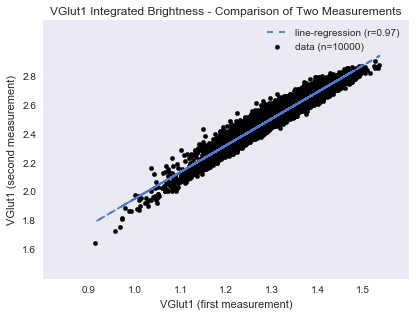

In [5]:
## LOAD IN THE DATA
# Log-transformed data
data = np.load('../data/synapse_f0_features_log.npy')
X = data  # extract only the features

############ DATA CHECKING ##################
# random scatter plot of synap vs synap and vglut1 and vglut1
# is it on linear line?
# -> can we average the values together? since they're measured in different time

## Downsample our data
X = data[np.random.choice(range(data.shape[0]), size=10000, replace=False), :]
print X.shape, '\n\n'

## Generate two linear fits
fit_synap = np.polyfit(X[:,0], X[:,1], 1)
fit_fn_synap = np.poly1d(fit_synap)
fit_vglut = np.polyfit(X[:,2], X[:,3], 1)
fit_fn_vglut = np.poly1d(fit_vglut)

slope, intercept, synap_r_value, p_value, std_err = stats.linregress(X[:,0], X[:,1])
slope, intercept, vglut_r_value, p_value, std_err = stats.linregress(X[:,2], X[:,3])

## Plot onto line the Synap01 and Synap02 and Vglut01 and Vglut02 [0 vs 1] and [2 vs 3]
fig = plt.figure(figsize=(6, 4.5))
ax = plt.gca()
ax.grid(False)
plt.scatter(X[:,0], X[:,1], marker='o', color='k', label='data (n=%i)' %(len(X)))
plt.plot(X[:,0], fit_fn_synap(X[:,0]), '--x', label='line-regression (r=%0.2f)' %(synap_r_value))
plt.xlabel('Synap (first measurement)')
plt.ylabel('Synap (second measurement)')
plt.title('Synap Integrated Brightness - Comparison of Two Measurements')
plt.yticks(np.arange(11, 16, 2), np.arange(11, 16, 2))
plt.xticks(np.arange(10, 14.5, 1), np.arange(10, 14.5, 1))
plt.legend(loc='upper left')
plt.tight_layout()

fig = plt.figure(figsize=(6, 4.5))
ax = plt.gca()
ax.grid(False)
plt.scatter(X[:,2], X[:,3], marker='o', color='k', label='data (n=%i)' %(len(X)))
plt.plot(X[:,2], fit_fn_vglut(X[:,2]), '--x', label='line-regression (r=%0.2f)' %(vglut_r_value))
plt.xlabel('VGlut1 (first measurement)')
plt.ylabel('VGlut1 (second measurement)')
plt.title('VGlut1 Integrated Brightness - Comparison of Two Measurements')
plt.yticks(np.arange(1.6, 2.9, 0.2), np.arange(1.6, 2.9, 0.2))
plt.xticks(np.arange(0.9, 1.6, 0.1), np.arange(0.9, 1.6, 0.1))
plt.legend(loc='best')
plt.tight_layout()

# Discussion On Data Checking
Looks linear to me....

Data we have now:
1. Log-transformed data
2. Log-normalized data
3. Squareroot-transformed data
4. Squareroot-normalized data


## LOAD F0 DATA FOR LOG TRANSFORMED
Load in log-transformed data and start running analysis

1. BIC of k-means with only excitatory and inhibitory synapses
2. Then remove bottom 25, 50, 75 % of synapsin values to downsample and try k-means again
3. kernel density estimates (tyler getting it)
4. try outlier detection

In [3]:
# http://stats.stackexchange.com/questions/90769/using-bic-to-estimate-the-number-of-k-in-kmeans
# definition for computing BIC
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)],
                                        [centers[0][i]], 'euclidean')**2) for i in range(m)])
    
    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)

351.763685621
[False False False False False False False  True False False False False
 False False False False False False False]


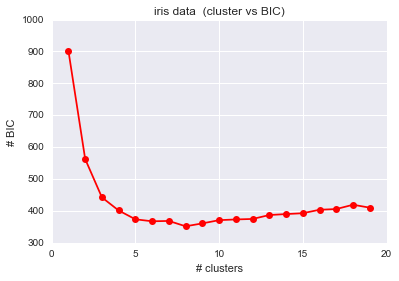

In [22]:
# IRIS DATA
iris = sklearn.datasets.load_iris()
X = iris.data[:, :4]  # extract only the features
#Xs = StandardScaler().fit_transform(X)
Y = iris.target

ks = range(1,20)

# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.KMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'r-o')
plt.title("iris data  (cluster vs BIC)")
plt.xlabel("# clusters")
plt.ylabel("# BIC")

print min(BIC)
print BIC==min(BIC)

## Filter By Synap Values
Here, I will filter by synap values at 25th, 50th and 75th percentile.

In [7]:
## LOAD IN THE DATA
# Log-transformed data
data = np.load('../data/synapse_f0_features_log.npy')
X = data  # extract only the features

## AVGE THE SYNAP AND VGLUT VALUES
synap_avg = np.reshape(np.mean((X[:,0], X[:,1]), axis=0), (len(X), 1))
vglut_avg = np.reshape(np.mean((X[:,2], X[:,3]), axis=0), (len(X), 1))
X = np.concatenate((synap_avg, vglut_avg, X[:,4:]), axis=1)
print X.shape

# Remove synapses corresponding to the bottom 25% synapsin values
# 5. Same as (4) at bottom 50%
# 6. Same as (5) at bottom 75%

# Xpd = pd.DataFrame(X)
# Xpd.groupby([0,1]).mean()
# print Xpd

(1119299, 22)


(839474, 22)
(559649, 22)
(279825, 22)


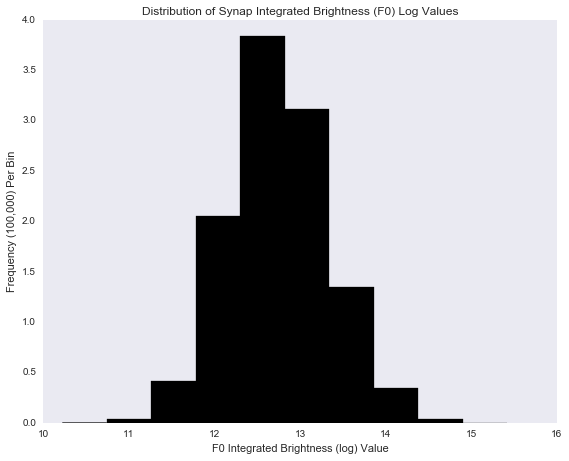

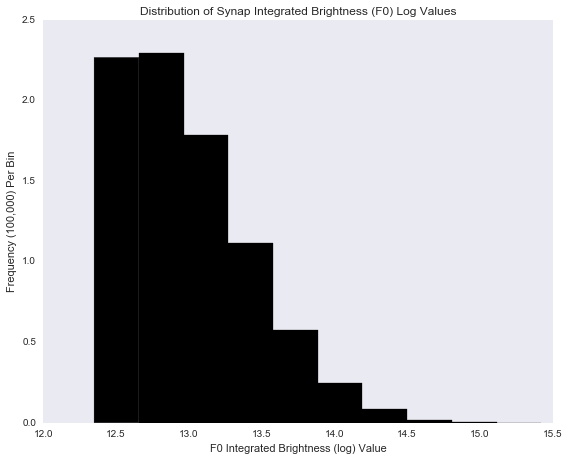

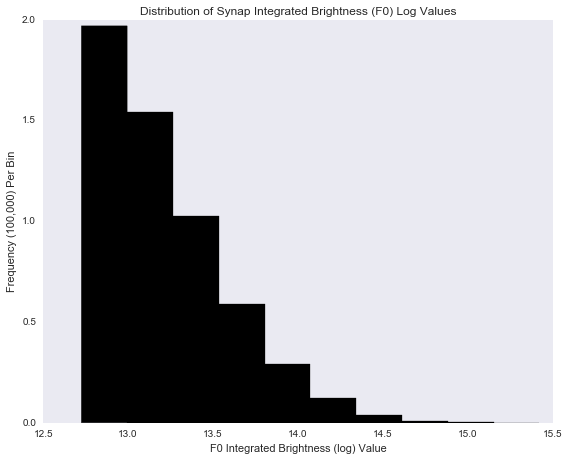

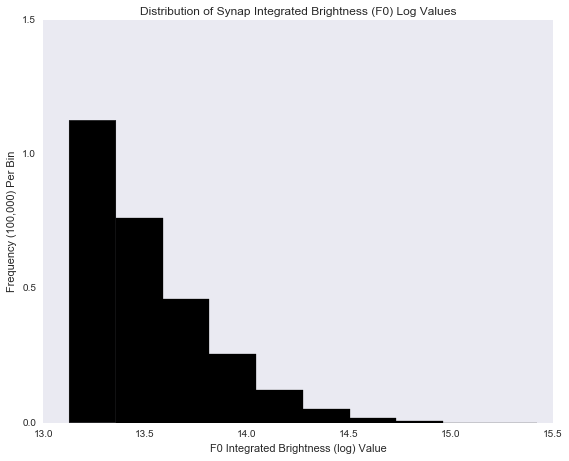

In [8]:
# get range of synap values
# 25th, 50th, and 75th percentile
# bottom_25 = np.percentile(X[:,0], 25)
# bottom_50 = np.percentile(X[:,0], 50)
# bottom_75 = np.percentile(X[:,0], 75)

bottom_25 = X[X[:,0] > np.percentile(X[:,0], 25)]
bottom_50 = X[X[:,0] > np.percentile(X[:,0], 50)]
bottom_75 = X[X[:,0] > np.percentile(X[:,0], 75)]
print bottom_25.shape
print bottom_50.shape
print bottom_75.shape

## Save data
np.save('../data/f0_features_log_normalized_bottom25.npy',bottom_25)
np.save('../data/f0_features_log_normalized_bottom50.npy',bottom_50)
np.save('../data/f0_features_log_normalized_bottom75.npy',bottom_75)

fig = plt.figure(figsize=(8,6.5))
ax = plt.gca()
ax.grid(False)
hist = plt.hist(X[:,0], color='k')    
plt.xlabel('F0 Integrated Brightness (log) Value')
plt.ylabel('Frequency (100,000) Per Bin')
plt.title('Distribution of Synap Integrated Brightness (F0) Log Values')
plt.yticks(np.arange(0, max(hist[0])+40000, 50000), np.arange(0.0, 4.3, 0.5))
# plt.xticks(np.arange(0.9, 1.6, 0.1), np.arange(0.9, 1.6, 0.1))
plt.tight_layout()

fig = plt.figure(figsize=(8,6.5))
ax = plt.gca()
ax.grid(False)
hist = plt.hist(bottom_25[:,0], color='k')    
plt.xlabel('F0 Integrated Brightness (log) Value')
plt.ylabel('Frequency (100,000) Per Bin')
plt.title('Distribution of Synap Integrated Brightness (F0) Log Values')
plt.yticks(np.arange(0, max(hist[0])+40000, 50000), np.arange(0.0, 4.3, 0.5))
# plt.xticks(np.arange(0.9, 1.6, 0.1), np.arange(0.9, 1.6, 0.1))
plt.tight_layout()

fig = plt.figure(figsize=(8,6.5))
ax = plt.gca()
ax.grid(False)
hist = plt.hist(bottom_50[:,0], color='k')    
plt.xlabel('F0 Integrated Brightness (log) Value')
plt.ylabel('Frequency (100,000) Per Bin')
plt.title('Distribution of Synap Integrated Brightness (F0) Log Values')
plt.yticks(np.arange(0, max(hist[0])+40000, 50000), np.arange(0.0, 4.3, 0.5))
# plt.xticks(np.arange(0.9, 1.6, 0.1), np.arange(0.9, 1.6, 0.1))
plt.tight_layout()

fig = plt.figure(figsize=(8,6.5))
ax = plt.gca()
ax.grid(False)
hist = plt.hist(bottom_75[:,0], color='k')    
plt.xlabel('F0 Integrated Brightness (log) Value')
plt.ylabel('Frequency (100,000) Per Bin')
plt.title('Distribution of Synap Integrated Brightness (F0) Log Values')
plt.yticks(np.arange(0, max(hist[0])+40000, 50000), np.arange(0.0, 4.3, 0.5))
# plt.xticks(np.arange(0.9, 1.6, 0.1), np.arange(0.9, 1.6, 0.1))
plt.tight_layout()

# For each Synap Filtered, Run BIC Test

In [7]:
### Run on bottom 25 percentile filtered synap stuff
data = np.load('../../data/f0_features_log_normalized_bottom25.npy')
X = data  # extract only the features

print X.shape
print 'channels: ', channel, '\n'
print 'channel types: ', channeltype, '\n'

channel_inhib_excit = ['ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small', 
               'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre', 
               'in.pre','in.post','in.post','in.post']

# get only the channels with known excitatory and inhibitory
channeltype = np.array(channeltype)
# inhib_excit_indices = [idx for idx, x in enumerate(channeltype) if x in channel_inhib_excit]
inhib_excit_indices = np.arange(0, len(channel_inhib_excit))


X = X[:,inhib_excit_indices]

(839474, 22)
channels:  ['Synap_01', 'Synap_02', 'VGlut1_01', 'VGlut1_02', 'VGlut2', 'Vglut3', 'psd', 'glur2', 'nmdar1', 'nr2b', 'gad', 'VGAT', 'PV', 'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'tubuli', 'DAPI'] 

channel types:  ['ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'in.pre.small', 'ex.post', 'ex.post', 'ex.post', 'ex.post', 'in.pre', 'in.pre', 'in.pre', 'in.post', 'in.post', 'in.post', 'in.pre.small', 'other', 'ex.post', 'other', 'other', 'ex.post', 'none', 'none'] 



For f0 features log transformed


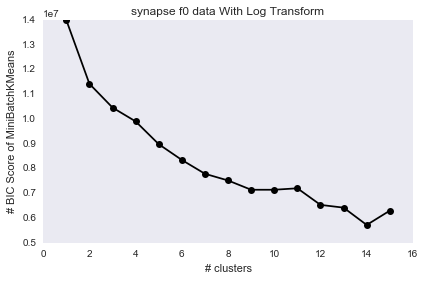

In [8]:
data = np.load('../../data/synapse_f0_features_log.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,16)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f0 data With Log Transform")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f0 features log transformed"

For f0 features log transformed and normalized


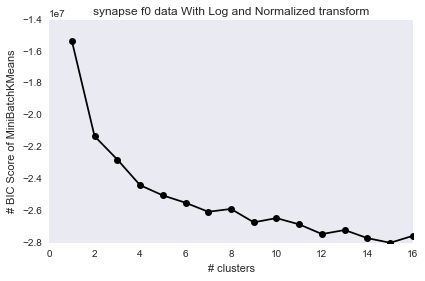

In [10]:
data = np.load('../../data/synapse_f0_features_log_normalized.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f0 data With Log and Normalized transform")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f0 features log transformed and normalized"

For f0 features Square Root Transform


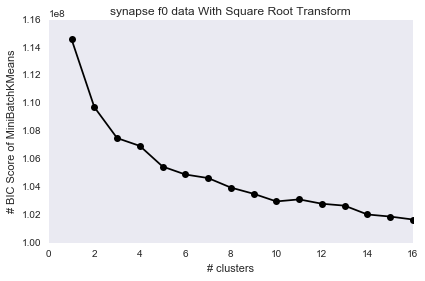

In [11]:
data = np.load('../../data/synapse_f0_features_sqrt.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run n times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f0 data With Square Root Transform")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()


print "For f0 features Square Root Transform"

For f0 features Square Root Transform and Normalized


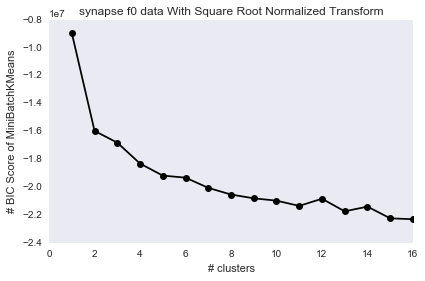

In [12]:
data = np.load('../../data/synapse_f0_features_sqrt_normalized.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run n times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f0 data With Square Root Normalized Transform")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
plt.tight_layout()
ax.grid(False)

print "For f0 features Square Root Transform and Normalized"

## Now Do 4 transformations BIC Plot With Filtered Synap Values
Filter at 25, 50 and 75% values

For f0 features Log Transform and Normalized Filtered out bottom 25%


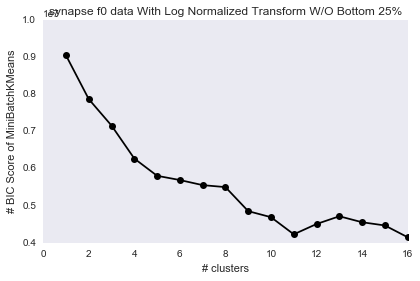

In [14]:
data = np.load('../../data/f0_features_log_normalized_bottom25.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run n times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f0 data With Log Normalized Transform W/O Bottom 25%")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
plt.tight_layout()
ax.grid(False)

print "For f0 features Log Transform and Normalized Filtered out bottom 25%"

For f0 features Log Transform and Normalized Filtered out bottom 50%


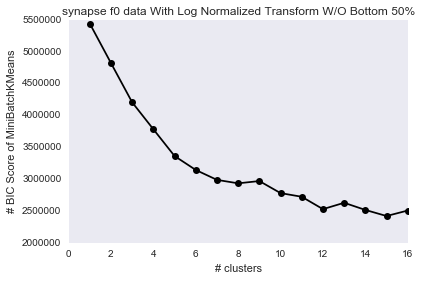

In [16]:
data = np.load('../../data/f0_features_log_normalized_bottom50.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run n times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f0 data With Log Normalized Transform W/O Bottom 50%")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
plt.tight_layout()
ax.grid(False)

print "For f0 features Log Transform and Normalized Filtered out bottom 50%"

For f0 features Log Transform and Normalized Filtered out bottom 75%


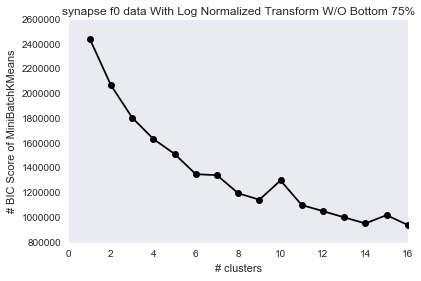

In [17]:
data = np.load('../../data/f0_features_log_normalized_bottom75.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run n times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f0 data With Log Normalized Transform W/O Bottom 75%")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
plt.tight_layout()
ax.grid(False)

print "For f0 features Log Transform and Normalized Filtered out bottom 75%"

## BIC Plots For Other Features

 f1 = local brightness f2 = distance to Center of Mass f3 = moment of inertia around synapse
 

### 01: First save all the data into npy files

In [8]:
## LOAD IN THE DATA
# Log-transformed data
list_of_features = np.load('../data/synapse_features_log.npy')
X = list_of_features  # extract only the features

X_f1 = list_of_features[:,24:48]
X_f2 = list_of_features[:,48:72]
X_f3 = list_of_features[:,72:96]
X = X_f1
np.save('../data/synapse_f1_features_log.npy',X)
X = X_f2
np.save('../data/synapse_f2_features_log.npy',X)
X = X_f3
np.save('../data/synapse_f3_features_log.npy',X)

In [9]:
## LOAD IN THE DATA
# Lognormalized-transformed data
list_of_features = np.load('../data/synapse_features_log_normalized.npy')
X = list_of_features  # extract only the features

X_f1 = list_of_features[:,24:48]
X_f2 = list_of_features[:,48:72]
X_f3 = list_of_features[:,72:96]
X = X_f1
np.save('../data/synapse_f1_features_log_normalized.npy',X)
X = X_f2
np.save('../data/synapse_f2_features_log_normalized.npy',X)
X = X_f3
np.save('../data/synapse_f3_features_log_normalized.npy',X)

In [10]:
## LOAD IN THE DATA
# Lognormalized-transformed data
list_of_features = np.load('../data/synapse_features_sqrt_normalized.npy')
X = list_of_features  # extract only the features

X_f1 = list_of_features[:,24:48]
X_f2 = list_of_features[:,48:72]
X_f3 = list_of_features[:,72:96]
X = X_f1
np.save('../data/synapse_f1_features_sqrt_normalized.npy',X)
X = X_f2
np.save('../data/synapse_f2_features_sqrt_normalized.npy',X)
X = X_f3
np.save('../data/synapse_f3_features_sqrt_normalized.npy',X)

In [11]:
## LOAD IN THE DATA
# Lognormalized-transformed data
list_of_features = np.load('../data/synapse_features_sqrt.npy')
X = list_of_features  # extract only the features

X_f1 = list_of_features[:,24:48]
X_f2 = list_of_features[:,48:72]
X_f3 = list_of_features[:,72:96]
X = X_f1
np.save('../data/synapse_f1_features_sqrt.npy',X)
X = X_f2
np.save('../data/synapse_f2_features_sqrt.npy',X)
X = X_f3
np.save('../data/synapse_f3_features_sqrt.npy',X)

# 02: Now redo analysis on all the data

### f1: local brightness

(100000, 24) 




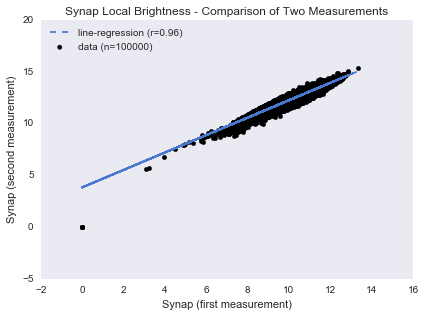

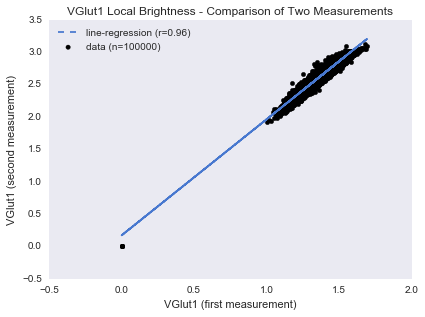

In [20]:
## LOAD IN THE DATA
# Log-transformed data
data = np.load('../../data/synapse_f1_features_log.npy')
X = data  # extract only the features

############ DATA CHECKING ##################
# random scatter plot of synap vs synap and vglut1 and vglut1
# is it on linear line?
# -> can we average the values together? since they're measured in different time

## Downsample our data
X = data[np.random.choice(range(data.shape[0]), size=100000, replace=False), :]
print X.shape, '\n\n'

## Generate two linear fits
fit_synap = np.polyfit(X[:,0], X[:,1], 1)
fit_fn_synap = np.poly1d(fit_synap)
fit_vglut = np.polyfit(X[:,2], X[:,3], 1)
fit_fn_vglut = np.poly1d(fit_vglut)

slope, intercept, synap_r_value, p_value, std_err = stats.linregress(X[:,0], X[:,1])
slope, intercept, vglut_r_value, p_value, std_err = stats.linregress(X[:,2], X[:,3])

## Plot onto line the Synap01 and Synap02 and Vglut01 and Vglut02 [0 vs 1] and [2 vs 3]
fig = plt.figure(figsize=(6, 4.5))
ax = plt.gca()
ax.grid(False)
plt.scatter(X[:,0], X[:,1], marker='o', color='k', label='data (n=%i)' %(len(X)))
plt.plot(X[:,0], fit_fn_synap(X[:,0]), '--x', label='line-regression (r=%0.2f)' %(synap_r_value))
plt.xlabel('Synap (first measurement)')
plt.ylabel('Synap (second measurement)')
plt.title('Synap Local Brightness - Comparison of Two Measurements')
# plt.yticks(np.arange(11, 16, 2), np.arange(11, 16, 2))
# plt.xticks(np.arange(10, 14.5, 1), np.arange(10, 14.5, 1))
plt.legend(loc='upper left')
plt.tight_layout()

fig = plt.figure(figsize=(6, 4.5))
ax = plt.gca()
ax.grid(False)
plt.scatter(X[:,2], X[:,3], marker='o', color='k', label='data (n=%i)' %(len(X)))
plt.plot(X[:,2], fit_fn_vglut(X[:,2]), '--x', label='line-regression (r=%0.2f)' %(vglut_r_value))
plt.xlabel('VGlut1 (first measurement)')
plt.ylabel('VGlut1 (second measurement)')
plt.title('VGlut1 Local Brightness - Comparison of Two Measurements')
# plt.yticks(np.arange(1.6, 2.9, 0.2), np.arange(1.6, 2.9, 0.2))
# plt.xticks(np.arange(0.9, 1.6, 0.1), np.arange(0.9, 1.6, 0.1))
plt.legend(loc='best')
plt.tight_layout()

(100000, 24) 




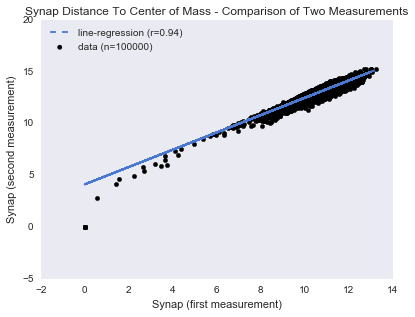

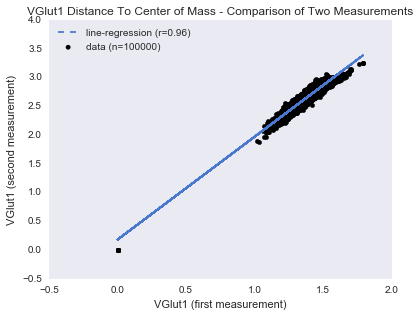

In [19]:
## LOAD IN THE DATA
# Log-transformed data
data = np.load('../data/synapse_f2_features_log.npy')
X = data  # extract only the features

############ DATA CHECKING ##################
# random scatter plot of synap vs synap and vglut1 and vglut1
# is it on linear line?
# -> can we average the values together? since they're measured in different time

## Downsample our data
X = data[np.random.choice(range(data.shape[0]), size=100000, replace=False), :]
print X.shape, '\n\n'

## Generate two linear fits
fit_synap = np.polyfit(X[:,0], X[:,1], 1)
fit_fn_synap = np.poly1d(fit_synap)
fit_vglut = np.polyfit(X[:,2], X[:,3], 1)
fit_fn_vglut = np.poly1d(fit_vglut)

slope, intercept, synap_r_value, p_value, std_err = stats.linregress(X[:,0], X[:,1])
slope, intercept, vglut_r_value, p_value, std_err = stats.linregress(X[:,2], X[:,3])

## Plot onto line the Synap01 and Synap02 and Vglut01 and Vglut02 [0 vs 1] and [2 vs 3]
fig = plt.figure(figsize=(6, 4.5))
ax = plt.gca()
ax.grid(False)
plt.scatter(X[:,0], X[:,1], marker='o', color='k', label='data (n=%i)' %(len(X)))
plt.plot(X[:,0], fit_fn_synap(X[:,0]), '--x', label='line-regression (r=%0.2f)' %(synap_r_value))
plt.xlabel('Synap (first measurement)')
plt.ylabel('Synap (second measurement)')
plt.title('Synap Distance To Center of Mass - Comparison of Two Measurements')
# plt.yticks(np.arange(11, 16, 2), np.arange(11, 16, 2))
# plt.xticks(np.arange(10, 14.5, 1), np.arange(10, 14.5, 1))
plt.legend(loc='upper left')
plt.tight_layout()

fig = plt.figure(figsize=(6, 4.5))
ax = plt.gca()
ax.grid(False)
plt.scatter(X[:,2], X[:,3], marker='o', color='k', label='data (n=%i)' %(len(X)))
plt.plot(X[:,2], fit_fn_vglut(X[:,2]), '--x', label='line-regression (r=%0.2f)' %(vglut_r_value))
plt.xlabel('VGlut1 (first measurement)')
plt.ylabel('VGlut1 (second measurement)')
plt.title('VGlut1 Distance To Center of Mass - Comparison of Two Measurements')
# plt.yticks(np.arange(1.6, 2.9, 0.2), np.arange(1.6, 2.9, 0.2))
# plt.xticks(np.arange(0.9, 1.6, 0.1), np.arange(0.9, 1.6, 0.1))
plt.legend(loc='best')
plt.tight_layout()

(100000, 24) 




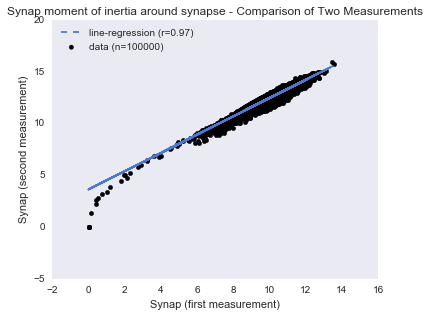

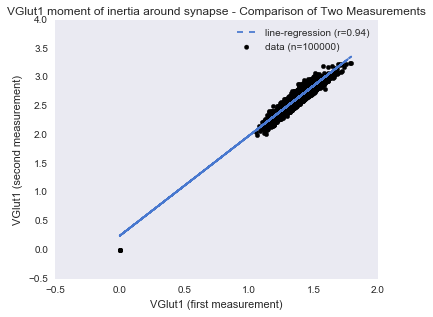

In [21]:
## LOAD IN THE DATA
# Log-transformed data
data = np.load('../data/synapse_f3_features_log.npy')
X = data  # extract only the features

############ DATA CHECKING ##################
# random scatter plot of synap vs synap and vglut1 and vglut1
# is it on linear line?
# -> can we average the values together? since they're measured in different time

## Downsample our data
X = data[np.random.choice(range(data.shape[0]), size=100000, replace=False), :]
print X.shape, '\n\n'

## Generate two linear fits
fit_synap = np.polyfit(X[:,0], X[:,1], 1)
fit_fn_synap = np.poly1d(fit_synap)
fit_vglut = np.polyfit(X[:,2], X[:,3], 1)
fit_fn_vglut = np.poly1d(fit_vglut)

slope, intercept, synap_r_value, p_value, std_err = stats.linregress(X[:,0], X[:,1])
slope, intercept, vglut_r_value, p_value, std_err = stats.linregress(X[:,2], X[:,3])

## Plot onto line the Synap01 and Synap02 and Vglut01 and Vglut02 [0 vs 1] and [2 vs 3]
fig = plt.figure(figsize=(6, 4.5))
ax = plt.gca()
ax.grid(False)
plt.scatter(X[:,0], X[:,1], marker='o', color='k', label='data (n=%i)' %(len(X)))
plt.plot(X[:,0], fit_fn_synap(X[:,0]), '--x', label='line-regression (r=%0.2f)' %(synap_r_value))
plt.xlabel('Synap (first measurement)')
plt.ylabel('Synap (second measurement)')
plt.title('Synap moment of inertia around synapse - Comparison of Two Measurements')
# plt.yticks(np.arange(11, 16, 2), np.arange(11, 16, 2))
# plt.xticks(np.arange(10, 14.5, 1), np.arange(10, 14.5, 1))
plt.legend(loc='upper left')
plt.tight_layout()

fig = plt.figure(figsize=(6, 4.5))
ax = plt.gca()
ax.grid(False)
plt.scatter(X[:,2], X[:,3], marker='o', color='k', label='data (n=%i)' %(len(X)))
plt.plot(X[:,2], fit_fn_vglut(X[:,2]), '--x', label='line-regression (r=%0.2f)' %(vglut_r_value))
plt.xlabel('VGlut1 (first measurement)')
plt.ylabel('VGlut1 (second measurement)')
plt.title('VGlut1 moment of inertia around synapse - Comparison of Two Measurements')
# plt.yticks(np.arange(1.6, 2.9, 0.2), np.arange(1.6, 2.9, 0.2))
# plt.xticks(np.arange(0.9, 1.6, 0.1), np.arange(0.9, 1.6, 0.1))
plt.legend(loc='best')
plt.tight_layout()

## 02: Discussion On Other Metrics
I'm randomly plotting 10,000 scatter points, but even then, it seems there are these small number of outliers for each f1, f2 and f3. 

However, this could be due to randomluy getting points?

Now I want to create BIC plots for excitatory/inhibitory synapse proteins only with the other metrics f1, f2, f3.

Here I will do it with: 

    log_normalized - filter at 0%, 25, 50, 75
    sqrt_normalized - filter at 0, 25, 50, 75%

In [23]:
## LOAD IN THE DATA
# Log-transformed data
data = np.load('../data/synapse_f1_features_log_normalized.npy')
X = data  # extract only the features

## AVGE THE SYNAP AND VGLUT VALUES
synap_avg = np.reshape(np.mean((X[:,0], X[:,1]), axis=0), (len(X), 1))
vglut_avg = np.reshape(np.mean((X[:,2], X[:,3]), axis=0), (len(X), 1))
X = np.concatenate((synap_avg, vglut_avg, X[:,4:]), axis=1)
print X.shape

(1119299, 22)


In [24]:
bottom_25 = X[X[:,0] > np.percentile(X[:,0], 25)]
bottom_50 = X[X[:,0] > np.percentile(X[:,0], 50)]
bottom_75 = X[X[:,0] > np.percentile(X[:,0], 75)]
print bottom_25.shape
print bottom_50.shape
print bottom_75.shape

## Save data
np.save('../data/f1_features_log_normalized_bottom25.npy',bottom_25)
np.save('../data/f1_features_log_normalized_bottom50.npy',bottom_50)
np.save('../data/f1_features_log_normalized_bottom75.npy',bottom_75)

(839474, 22)
(559649, 22)
(279825, 22)


In [32]:
## LOAD IN THE DATA
# Log-transformed data
data = np.load('../data/synapse_f2_features_log_normalized.npy')
X = data  # extract only the features

## AVGE THE SYNAP AND VGLUT VALUES
synap_avg = np.reshape(np.mean((X[:,0], X[:,1]), axis=0), (len(X), 1))
vglut_avg = np.reshape(np.mean((X[:,2], X[:,3]), axis=0), (len(X), 1))
X = np.concatenate((synap_avg, vglut_avg, X[:,4:]), axis=1)
print X.shape

bottom_25 = X[X[:,0] > np.percentile(X[:,0], 25)]
bottom_50 = X[X[:,0] > np.percentile(X[:,0], 50)]
bottom_75 = X[X[:,0] > np.percentile(X[:,0], 75)]
print bottom_25.shape
print bottom_50.shape
print bottom_75.shape

## Save data
np.save('../data/f2_features_log_normalized_bottom25.npy',bottom_25)
np.save('../data/f2_features_log_normalized_bottom50.npy',bottom_50)
np.save('../data/f2_features_log_normalized_bottom75.npy',bottom_75)

(1119299, 22)
(839474, 22)
(559649, 22)
(279825, 22)


In [33]:
## LOAD IN THE DATA
# Log-transformed data
data = np.load('../data/synapse_f3_features_log_normalized.npy')
X = data  # extract only the features

## AVGE THE SYNAP AND VGLUT VALUES
synap_avg = np.reshape(np.mean((X[:,0], X[:,1]), axis=0), (len(X), 1))
vglut_avg = np.reshape(np.mean((X[:,2], X[:,3]), axis=0), (len(X), 1))
X = np.concatenate((synap_avg, vglut_avg, X[:,4:]), axis=1)
print X.shape

bottom_25 = X[X[:,0] > np.percentile(X[:,0], 25)]
bottom_50 = X[X[:,0] > np.percentile(X[:,0], 50)]
bottom_75 = X[X[:,0] > np.percentile(X[:,0], 75)]
print bottom_25.shape
print bottom_50.shape
print bottom_75.shape

## Save data
np.save('../data/f3_features_log_normalized_bottom25.npy',bottom_25)
np.save('../data/f3_features_log_normalized_bottom50.npy',bottom_50)
np.save('../data/f3_features_log_normalized_bottom75.npy',bottom_75)

(1119299, 22)
(839474, 22)
(559649, 22)
(279825, 22)


In [25]:
print 'channels: ', channel, '\n'
print 'channel types: ', channeltype, '\n'

channel_inhib_excit = ['ex.pre','ex.pre','ex.pre','ex.pre','ex.pre','in.pre.small', 
               'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre', 
               'in.pre','in.post','in.post','in.post']

# get only the channels with known excitatory and inhibitory
channeltype = np.array(channeltype)
inhib_excit_indices = [idx for idx, x in enumerate(channeltype) if x in channel_inhib_excit]

channels:  ['Synap_01', 'Synap_02', 'VGlut1_01', 'VGlut1_02', 'VGlut2', 'Vglut3', 'psd', 'glur2', 'nmdar1', 'nr2b', 'gad', 'VGAT', 'PV', 'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'tubuli', 'DAPI'] 

channel types:  ['ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'ex.pre', 'in.pre.small', 'ex.post', 'ex.post', 'ex.post', 'ex.post', 'in.pre', 'in.pre', 'in.pre', 'in.post', 'in.post', 'in.post', 'in.pre.small', 'other', 'ex.post', 'other', 'other', 'ex.post', 'none', 'none'] 



#### BIC Plots Now For F1 log normalized -> 0, 25, 50, 75% filtered

For f1 features log transformed and normalized


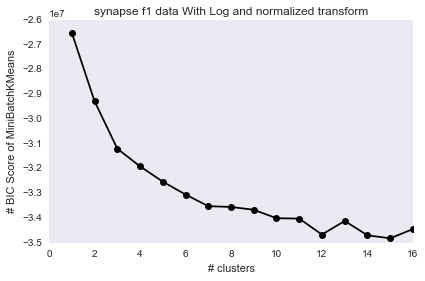

In [22]:
data = np.load('../../data/synapse_f1_features_log_normalized.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f1 data With Log and normalized transform")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f1 features log transformed and normalized"

For f1 features log transformed and normalized filtering out bottom 25% Synap


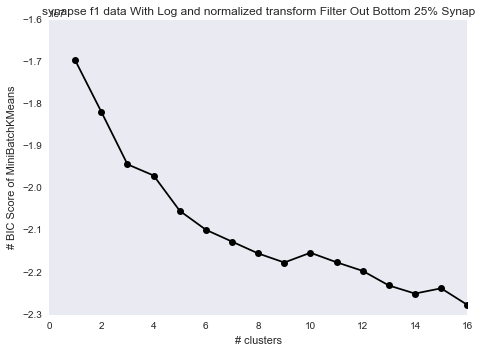

In [37]:
data = np.load('../../data/f1_features_log_normalized_bottom25.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig = plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f1 data With Log and normalized transform Filter Out Bottom 25% Synap")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f1 features log transformed and normalized filtering out bottom 25% Synap"

For f1 features log transformed and normalized filtering out bottom 50% Synap


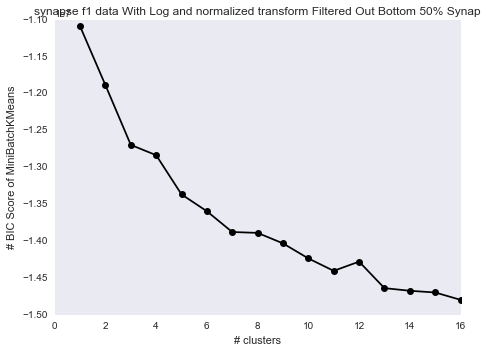

In [38]:
data = np.load('../../data/f1_features_log_normalized_bottom50.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig = plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f1 data With Log and normalized transform Filtered Out Bottom 50% Synap")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f1 features log transformed and normalized filtering out bottom 50% Synap"

For f1 features log transformed and normalized filtering out bottom 75% Synap


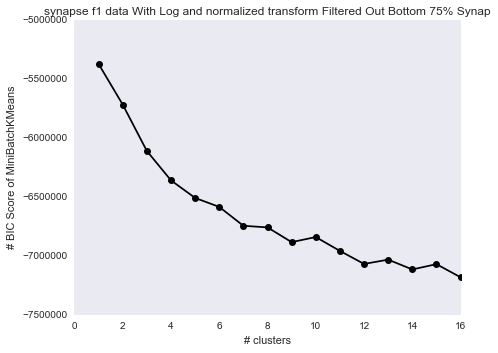

In [39]:
data = np.load('../../data/f1_features_log_normalized_bottom75.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig = plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f1 data With Log and normalized transform Filtered Out Bottom 75% Synap")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f1 features log transformed and normalized filtering out bottom 75% Synap"

#### BIC Plots for F2
Going to try kmeans on 6 clusters and compare with ground truths of inhibitory and excitatory...

For f2 features log transformed and normalized


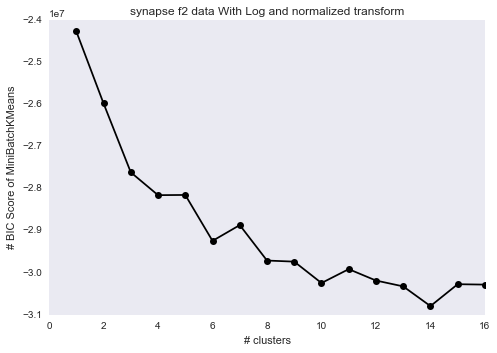

In [40]:
data = np.load('../../data/synapse_f2_features_log_normalized.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig=plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f2 data With Log and normalized transform")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f2 features log transformed and normalized"

For f2 features log transformed and normalized filtering out bottom 25% Synap


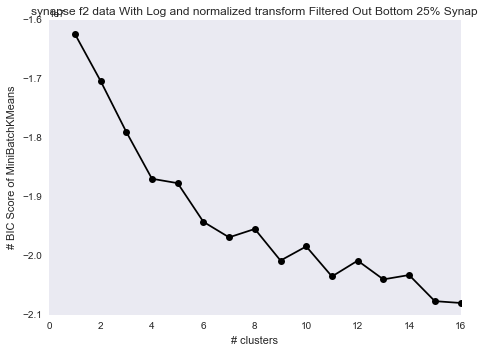

In [41]:
data = np.load('../../data/f2_features_log_normalized_bottom25.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig=plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f2 data With Log and normalized transform Filtered Out Bottom 25% Synap")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f2 features log transformed and normalized filtering out bottom 25% Synap"

For f2 features log transformed and normalized filtering out bottom 50% Synap


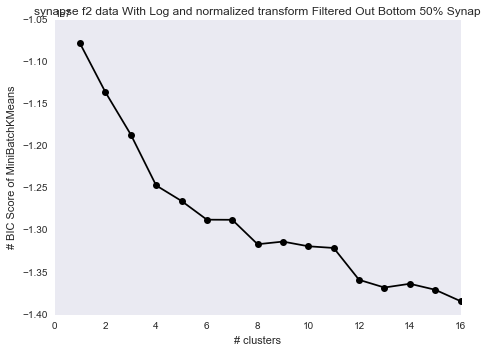

In [42]:
data = np.load('../../data/f2_features_log_normalized_bottom50.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig=plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f2 data With Log and normalized transform Filtered Out Bottom 50% Synap")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f2 features log transformed and normalized filtering out bottom 50% Synap"

For f2 features log transformed and normalized filtering out bottom 75% Synap


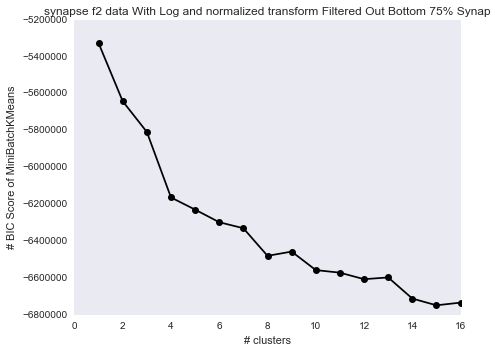

In [43]:
data = np.load('../../data/f2_features_log_normalized_bottom75.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig=plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f2 data With Log and normalized transform Filtered Out Bottom 75% Synap")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f2 features log transformed and normalized filtering out bottom 75% Synap"

#### BIC Plots for F3

For f3 features log transformed and normalized


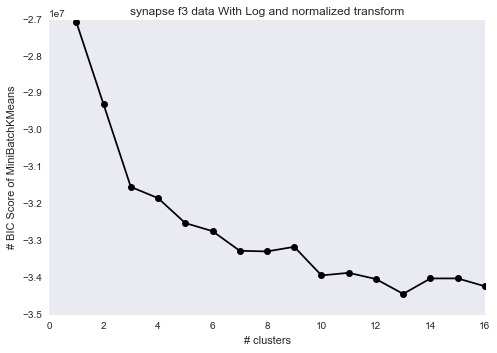

In [44]:
data = np.load('../../data/synapse_f3_features_log_normalized.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig=plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f3 data With Log and normalized transform")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f3 features log transformed and normalized"

For f3 features log transformed and normalized filtering out bottom 25% Synap


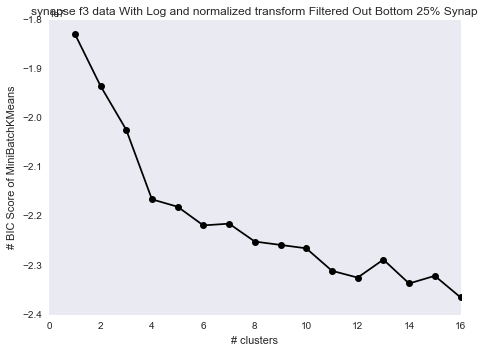

In [45]:
data = np.load('../../data/f3_features_log_normalized_bottom25.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig=plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f3 data With Log and normalized transform Filtered Out Bottom 25% Synap")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f3 features log transformed and normalized filtering out bottom 25% Synap"

For f3 features log transformed and normalized filtering out bottom 50% Synap


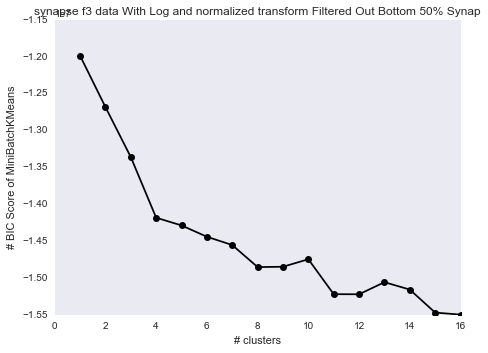

In [46]:
data = np.load('../../data/f3_features_log_normalized_bottom50.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig=plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f3 data With Log and normalized transform Filtered Out Bottom 50% Synap")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f3 features log transformed and normalized filtering out bottom 50% Synap"

For f3 features log transformed and normalized filtering out bottom 75% Synap


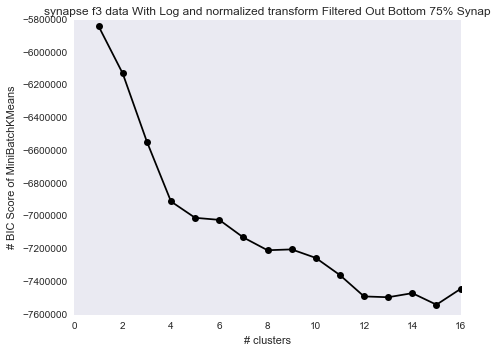

In [47]:
data = np.load('../../data/f3_features_log_normalized_bottom75.npy')
X = data  # extract only the features
X = X[:,inhib_excit_indices]

ks = range(1,17)
# run 9 times kmeans and save each result in the KMeans object
KMeans = [cluster.MiniBatchKMeans(n_clusters = i, init="k-means++").fit(X) for i in ks]

# now run for each cluster the BIC computation
BIC = [-compute_bic(kmeansi,X) for kmeansi in KMeans]

fig=plt.figure(figsize=(7,5))
plt.plot(ks,BIC,'k-o')
ax=plt.gca()
plt.title("synapse f3 data With Log and normalized transform Filtered Out Bottom 75% Synap")
plt.xlabel("# clusters")
plt.ylabel("# BIC Score of MiniBatchKMeans")
ax.grid(False)
plt.tight_layout()

print "For f3 features log transformed and normalized filtering out bottom 75% Synap"

## Try K-Means With 4, 5, 6 and Compare With Ground Truths
